In [17]:
import numpy as np
from PIL import Image
## Data domain

## NCOLS and NROWS are the number of columns and rows in the raster defined by the ASCII file
N_COLS = 42
N_ROWS = 25

## XLLCORNER and YLLCORNER are the coordinates of the lower left corner of the lower left cell
XLL_CORNER = 14.000
YLL_CORNER = 49.000

## CELLSIZE is the cell size of the raster.
CELL_SIZE = 0.25

NO_DATA_VALUE = -99
UNIT = "mm"

import glob, os
import re
from datetime import datetime

data_path = "./data"
data_datetime_pattern = re.compile(r'^.*PERSIANN_6h(\d{10}).tif$')

def getDateTimeFromFileName(file_name):
    date_time_string = data_datetime_pattern.search(file_name).group(1)
    return datetime.strptime(date_time_string, '%Y%m%d%H')

def getTiffFileAsArray(file_name):
    return np.asarray(Image.open(file_name))
        

# get all files containing data
all_files = glob.glob(os.path.join(data_path, '*.tif'), recursive=False)

# load data into array of tuples
data = [(getDateTimeFromFileName(f), getTiffFileAsArray(f)) for f in all_files]


In [25]:
# convert array of tuples to to pandas dataframe
import pandas as pd
import math

def cell_to_pandas(data, x, y):
    """
    Gets data for given cell and sorts by date
    """
    series = sorted([(date_time, percipitation[y, x]) for date_time, percipitation in data if percipitation[y, x] >= 0], key=itemgetter(0))
    if series:
        index, data = zip(*series)
        return pd.DataFrame(
            data=data,
            index=index,
            columns=["percipitation"]
        )
    else:
        return None

pd_data = []
for row in range(N_ROWS):
    pd_data_row = []
    for col in range(N_COLS):
        pd_data_row.append(cell_to_pandas(data, col, row))
    pd_data.append(pd_data_row)

rainfall_data = pd_data[5][20]
rainfall_data

,percipitation
2019-01-01 00:00:00,0.00
2019-01-01 06:00:00,0.00
2019-01-01 12:00:00,0.00
2019-01-01 18:00:00,0.00
2019-01-02 00:00:00,0.00
...,...
2019-12-30 00:00:00,0.42
2019-12-30 06:00:00,0.29
2019-12-30 12:00:00,0.51
2019-12-30 18:00:00,0.00


<h1>The model</h1>

As suggested by a review on rainfall prediction [1], ANN based models do best for this particular task. Furthermore, as suggested by literature on rainfall prediction using ANNs, 3 hidden layers were used [2]

[1] https://www.researchgate.net/publication/319503839_Machine_Learning_Techniques_For_Rainfall_Prediction_A_Review
[2] https://www.researchgate.net/publication/260739937_A_rainfall_prediction_model_using_artificial_neural_network

<h1>Visualizing the data</h1>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

Text(0.5, 1.0, 'Precipitation [mm] across months')

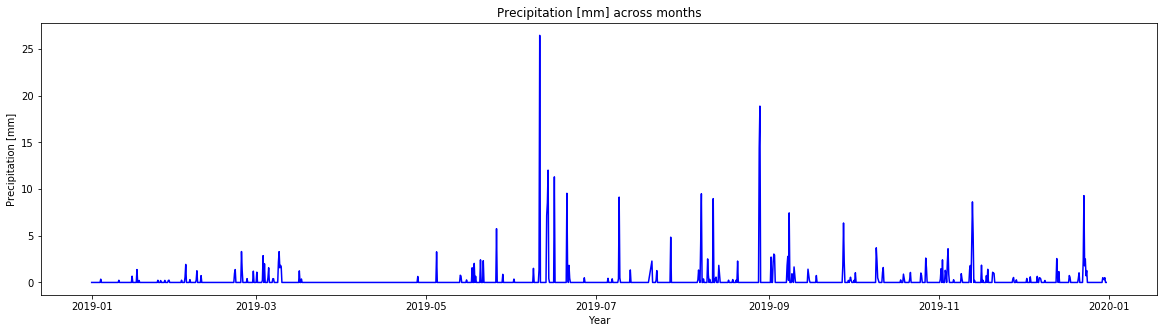

In [54]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation [mm]')
plt.title('Precipitation [mm] across months')

<h2>Aggregate data to days<h2>

Text(0.5, 1.0, 'Daily mean Precipitation [mm]')

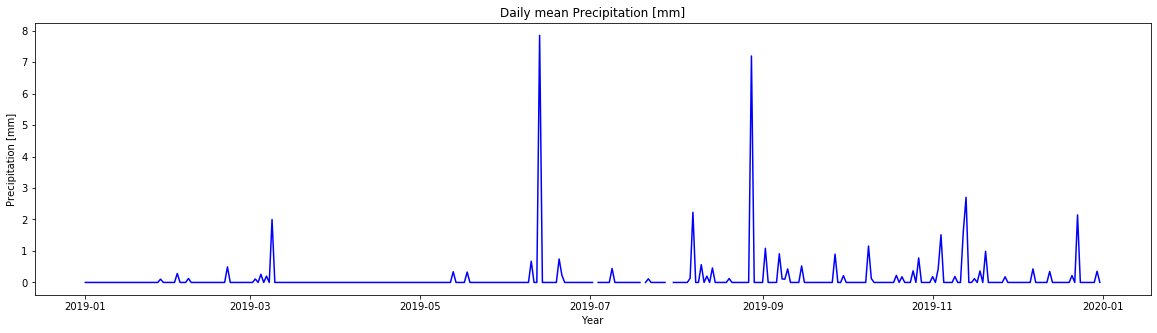

In [55]:
rainfall_data_daily = rainfall_data.groupby(pd.Grouper(freq='D')).median()

plt.figure(figsize=(20,5))
plt.plot(rainfall_data_daily, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation [mm]')
plt.title('Daily mean Precipitation [mm]')

<h2>Seven days moving avergage</h2>

> Moving Average - The idea with moving average is to remove all the zigzag motion from the time series to produce a steady trend through averaging adjacent values of a time period.

Text(0.5, 1.0, '4 Months Moving Average')

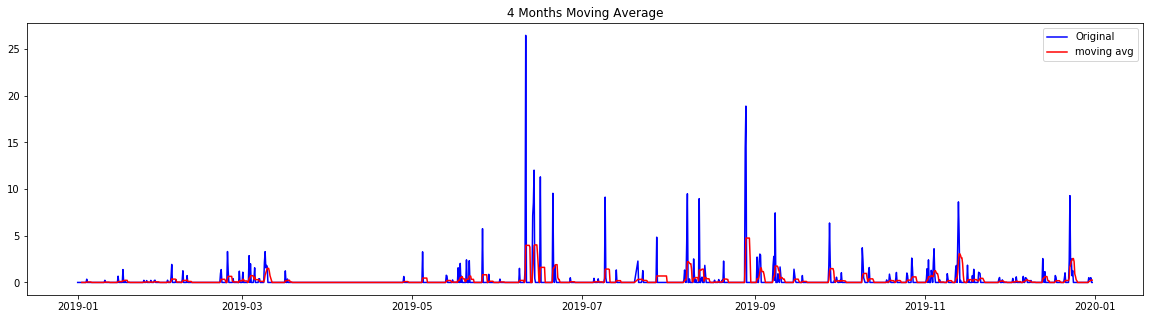

In [61]:
plt.figure(figsize=(20,5))
four_months_moving_average = rainfall_data.rolling(window=7).mean()
plt.plot(rainfall_data, color='blue', label='Original')
plt.plot(four_months_moving_average, color='red', label='moving avg')
plt.legend(loc='best')
plt.title('4 Months Moving Average')

<h1>Linear regression model approach</h1>
Prediction is based on percipitation in previous days

<h2>Prepare training data</h2>

In [87]:
# Find all data series without missing data for training
def get_cell_series(x, y, min_series):
    """
    Gets data for given cell with at least min_series points between unknown data 
    """
    if pd_data[y][x] is None:
        return []

    rainfall_data_daily = pd_data[y][x].groupby(pd.Grouper(freq='D')).median()
    sorted_data = sorted([(date_time, row['percipitation']) for date_time, row in rainfall_data_daily.iterrows()], key=itemgetter(0))
    series = []
    current_series = []
    for date_time, datum in sorted_data:
        if datum >= 0:
            current_series.append((date_time, datum))
        elif current_series:
            series.append(current_series)
            current_series = []
    if current_series:
        series.append(current_series)
    return series

percipitation_series = []
for row in range(N_ROWS):
    for col in range(N_COLS):
        percipitation_series.extend(get_cell_series(col, row, 10))

In [211]:
# Prepare training data, features:
# diff between percipitation 3 days ago and 2 days ago
# diff between percipitation 2 days ago and 1 day ago
# mean percipitation in last 3 days
# day of the year
# last percipitation
import math

def calculate_features(series):
    """
    :param series: a list of (date, percipitation)
    """
    _features = [series[i*2+1][1] - series[i*2][1] for i in range(math.floor(len(series) / 2))]
    _features.append(np.mean([d for _, d in series]))
    _features.append(series[-1][0].timetuple().tm_yday / 365)
    _features.append(series[-1][1])
    return _features

def training_data_for(series, window):
    features = []
    outputs = []
    dates = []
    for i, datum in enumerate(series[window:]):
        features.append(calculate_features(series[i : i + window]))
        outputs.append(datum[1])
        dates.append(datum[0])
    return (features, outputs, dates)
    
window = 3
features = []
outputs = []
for series in percipitation_series:
    _features, _outputs, _ = training_data_for(series, window)
    features.extend(_features)
    outputs.extend(_outputs)

features = np.array(features, dtype=np.float32)
outputs = np.array(outputs, dtype=np.float32)

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, outputs, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train, y_train)

reg.score(X_test, y_test)

0.007881328502515883

<h2>Predicting next day</h2>

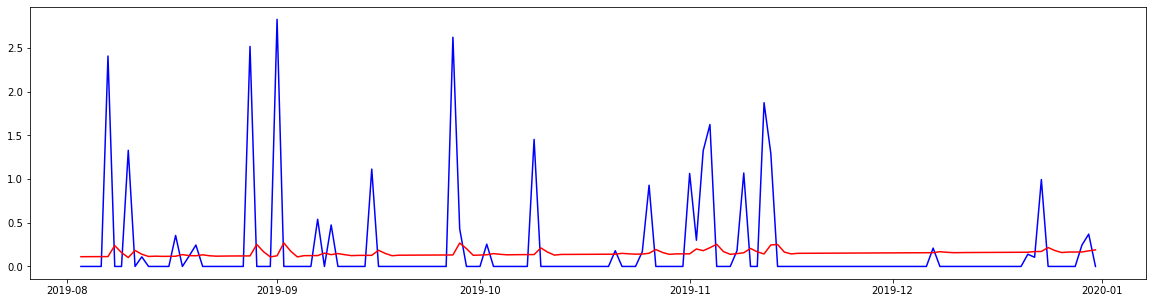

In [213]:
plt.figure(figsize=(20,5))
sample_features, sample_outputs, sample_dates = training_data_for(percipitation_series[15], window)
plt.plot(sample_dates, sample_outputs, color='blue', label='original')
plt.plot(sample_dates, reg.predict(sample_features), color='red', label='predicted')

<h2>Predicting next N days</h2>

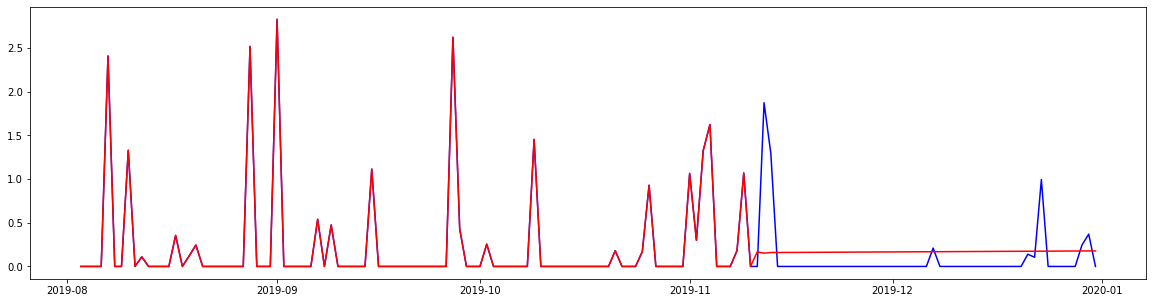

In [214]:
sample_features, sample_outputs, sample_dates = training_data_for(percipitation_series[15], window)
days_forward = 3
predictions = []
predictions_features = []
for i in range(len(sample_outputs)):
    if i < 100:
        predictions.append(sample_outputs[i])
        predictions_features.append(sample_features[i])
    else:
        f = calculate_features(list(zip(sample_dates[i - window:], predictions[i - window:])))
        p = reg.predict(np.array([f]))
        predictions.append(p)
        predictions_features.append(f)

plt.figure(figsize=(20,5))
plt.plot(sample_dates, sample_outputs, color='blue', label='original')
plt.plot(sample_dates, predictions, color='red', label='predicted')

<h2>ANN model approach</h2>
Prediction is based on percipitation in previous days

In [225]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'hidden_layer_sizes': [(10,20,20), (20,10,10), (10,10,10), (15, 20, 15)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.002, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

mlp_reg_template = MLPRegressor(max_iter=1000, shuffle=True, verbose=False)
mlp_reg = GridSearchCV(mlp_reg_template, parameter_space, n_jobs=-1, cv=3)
mlp_reg.fit(X_train, y_train)

print('Best parameters found:\n', mlp_reg.best_params_)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.002, 'hidden_layer_sizes': (10, 20, 20), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [228]:
mlp_reg = MLPRegressor(activation='relu', alpha=0.002, hidden_layer_sizes=(10,20,20), learning_rate='adaptive', solver='adam', max_iter=1000, shuffle=True, verbose=False).fit(X_train, y_train)
mlp_reg.score(X_test, y_test)

0.021805129813627144

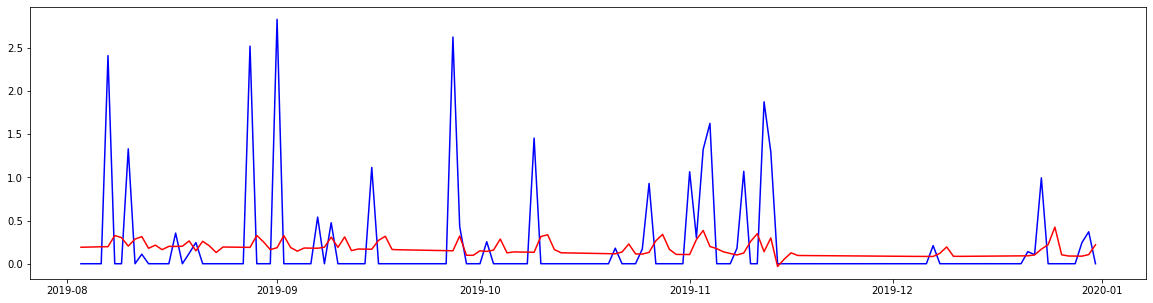

In [229]:
plt.figure(figsize=(20,5))
sample_features, sample_outputs, sample_dates = training_data_for(percipitation_series[15], window)
plt.plot(sample_dates, sample_outputs, color='blue', label='original')
plt.plot(sample_dates, mlp_reg.predict(sample_features), color='red', label='predicted')

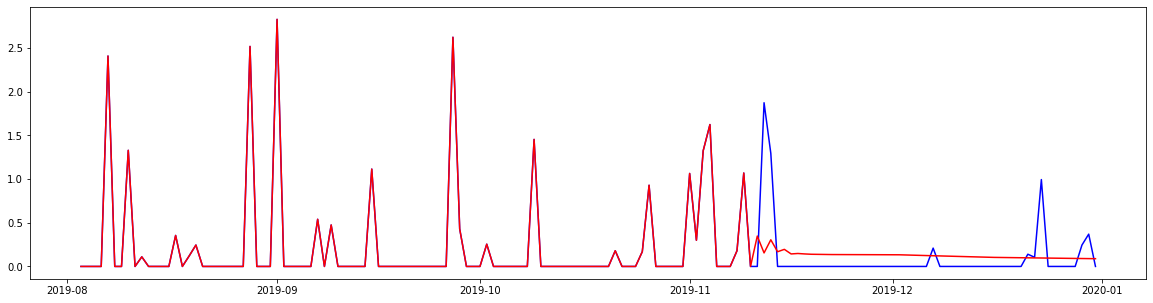

In [230]:
sample_features, sample_outputs, sample_dates = training_data_for(percipitation_series[15], window)
days_forward = 3
predictions = []
predictions_features = []
for i in range(len(sample_outputs)):
    if i < 100:
        predictions.append(sample_outputs[i])
        predictions_features.append(sample_features[i])
    else:
        f = calculate_features(list(zip(sample_dates[i - window:], predictions[i - window:])))
        p = mlp_reg.predict(np.array([f]))
        predictions.append(p)
        predictions_features.append(f)

plt.figure(figsize=(20,5))
plt.plot(sample_dates, sample_outputs, color='blue', label='original')
plt.plot(sample_dates, predictions, color='red', label='predicted')